# Lungs Segmentation
The segmentation of lungs may, possibly, proceed directly in 3D as follows:
1. Run binarization of the CT image using a threshold of -320 HU – every voxel
with HU lower than this threshold should receive label 1 (air label) and the
remaining voxels should receive label 0
2. Use body mask to select only air regions within body
3. Design a sequence of morphological (and other appropriate) operations to fill
the holes in the interior of lungs and to remove ‘air’ clusters which do not
correspond to lungs (e.g. gas in bowels) – at the end one should be left with
clusters which correspond only to airways
4. Use watershed from markers (scikit-image -> segmentation -> watershed) to
extract the left and the right lung from the segmentation being the result of step
(3) above. Before using watershed design a procedure for defining the three
markers (marker of left lung, marker of right lung, marker of background).
5. To compare segmentation results with reference segmentations available at
Lab One Drive use Dice coefficient and Hausdorff distance (find the definitions of
these   quantities)   as   implemented   in   surface-distance   [package](https://github.com/google-deepmind/surface-distance).
The project results (Dice coefficients and Hausdorff distance) should be
reported   for   the   three   tasks:   body   mask   segmentation,   left   lung
segmentation, right lung segmentation.


## Imports

In [155]:
import numpy as np
import nibabel as nib
import cv2
from skimage import morphology, measure
from skimage.segmentation import watershed
from skimage import filters
from scipy import ndimage
import matplotlib.pyplot as plt
# from pycimg import CImg

import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import reconstruction
from skimage.segmentation import flood, flood_fill


## Load / save .nii files and Visualization

In [156]:
def load_nii_gz_file(file_path: str) -> tuple:
    nii_img = nib.load(file_path)
    nii_data = nii_img.get_fdata()
    return nii_data, nii_img.affine

def save_to_nii(segmented_data: np.ndarray, affine: np.ndarray, output_path: str) -> None:
    segmented_nii = nib.Nifti1Image(segmented_data.astype(np.uint8), affine)
    nib.save(segmented_nii, output_path)
    
def view_nii_data(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def visualize_photos(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, *slices: int) -> None:
    num_slices = len(slices)
    plt.figure(figsize=(15, 5 * num_slices))  # Adjust figure size based on the number of slices

    for i, slice_num in enumerate(slices):
        # Original slice
        plt.subplot(num_slices, 3, 3 * i + 1)
        plt.title(f"Original Slice {slice_num}")
        plt.imshow(original[:, :, slice_num], cmap="gray")
        
        # Segmented slice
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.title(f"Segmented Slice {slice_num}")
        plt.imshow(segmented[:, :, slice_num], cmap="gray")
        
        # Reference slice
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.title(f"Reference Slice {slice_num}")
        plt.imshow(reference[:, :, slice_num], cmap="gray")

    plt.tight_layout() 
    plt.show()

## 1. Body differentiation

In [157]:
class Transforms:
    def __init__(self):
        pass
        
    def binarize_images(self, image: np.ndarray, threshold: float = -320, use_otsu: bool = False) -> np.ndarray:
        threshold = filters.threshold_otsu(image) if use_otsu else threshold
        image = np.where(image < threshold, 1, 0)
        return image.astype(np.uint8)
    
    def binarize_images_dual_threshold(self, image: np.ndarray, body_mask: np.ndarray, low_threshold: float = -320, high_threshold: float = -100) -> np.ndarray:
        return (image > low_threshold) * (image < high_threshold) * body_mask
    
    def binarize_images_kmeans(self, image: np.ndarray, max_iter: int = 100) -> float:
        min_val = image.min()
        not_background = image > min_val
        img_not_background = image * not_background
        
        threshold = img_not_background.sum() / not_background.sum()
        prev_threshold = 0
        
        for _ in range(max_iter):
            foreground_mask = image > threshold
            background_mask = image <= threshold
            
            foreground = img_not_background * foreground_mask
            background = img_not_background * background_mask
            
            avg_foreground = foreground.sum() / foreground_mask.sum()
            avg_background = background.sum() / background_mask.sum()
            
            new_threshold = (avg_foreground + avg_background) / 2
            
            if abs(new_threshold - prev_threshold) < 0.1:
                threshold = new_threshold
                break
            
            prev_threshold = threshold
            threshold = new_threshold
        
        print(f"threshold: {threshold}")
            
        image = (image > threshold) * not_background
        
        return image.astype(np.uint8)

In [158]:
class BodyMask(Transforms):
    def __init__(self, image: np.ndarray) -> None:
        self.img: np.ndarray = image
        
    def initial_transform(self) -> np.ndarray:
        binary_image = self.binarize_images_kmeans(self.img)
        opened_img = morphology.binary_opening(binary_image, morphology.ball(2))
        
        # visualize_photos(self.img, opened_img, self.img, 30, 60, 90, 110)
        self.img = opened_img
        
    
    def reconstruct_3d(self) -> np.ndarray:
        labels = label(self.img, connectivity=1)
        regions = regionprops(labels)
        largest_region = max(regions, key=lambda x: x.area)
        largest_region_mask = labels == largest_region.label
        
        mask = largest_region_mask
        neg_mask = np.logical_not(mask)
        
        seed = np.zeros_like(mask)
        list_of_corners = [(0, 0, 0), (0, 0, -1), (0, -1, 0), (-1, 0, 0), (-1, -1, -1), (-1, -1, 0), (-1, 0, -1), (0, -1, -1)]
        for corner in list_of_corners:
            seed[corner] = 1
        
        reconstructed = reconstruction(seed, neg_mask)
        insert_part = 1 - reconstructed
        
        return insert_part
    
    def flood_fill_3d(self, seed_point: tuple = (0, 0, 0)) -> np.ndarray:
        labels = label(self.img, connectivity=1)
        regions = regionprops(labels)
        largest_region = max(regions, key=lambda x: x.area)
        
        neg_mask = (labels == largest_region.label) * 1
        mask = flood(neg_mask, seed_point)
        mask = np.logical_not(mask)
        return mask


## Lung segmentation

In [159]:
class LungSegmentation(Transforms):
    def __init__(self, image: np.ndarray, body_mask: np.ndarray) -> None:
        self.og_img: np.ndarray = image[:]
        self.img: np.ndarray = image
        self.body_mask: np.ndarray = body_mask
        
    def histogram(self) -> None:
        plt.hist(self.img.ravel(), bins=256, range=(self.img.min()+1, self.img.max()-1), fc='k', ec='k')
        plt.show()
        
    def __cut_out_body(self) -> np.ndarray:
        min_val = self.img.min()
        self.img = self.img * self.body_mask + min_val * (1 - self.body_mask)
        
    def __find_lung_histogram_peak(self) -> float:
        histogram = np.histogram(self.img, bins=256, range=(self.img.min()+1, -200))
        lung_peak_index = np.argmax(histogram[0][1:]) + 1
        lung_peak_value = histogram[1][lung_peak_index]
        return lung_peak_value

    def initial_transform(self) -> np.ndarray:
        self.__cut_out_body()
        
        # binarization
        self.histogram()
        lung_peak_value = self.__find_lung_histogram_peak()
        binary_image = self.binarize_images_dual_threshold(self.img, self.body_mask, max(lung_peak_value - 100, self.img.min() + 1), lung_peak_value + 100)
        
        # fill holes
        binary_image = ndimage.binary_fill_holes(binary_image)
        binary_image = morphology.binary_closing(binary_image, morphology.ball(3))
        binary_image = morphology.binary_dilation(binary_image, morphology.ball(2))
        self.img = binary_image
        
    def remove_trachea(self, trachea_histogram_value: int = -950) -> np.ndarray:
        # reverse binarization
        min_value = self.og_img.min()
        self.img = self.img * self.og_img + min_value * (1 - self.img)

        # find trachea using density histogram
        trachea_mask = (self.img < trachea_histogram_value) * (self.img > min_value)

        # find largest region
        labels = label(trachea_mask, connectivity=1)
        regions = regionprops(labels)
        largest_region = max(regions, key=lambda x: x.area)
        trachea_mask = labels == largest_region.label
        trachea_mask = morphology.binary_dilation(trachea_mask, morphology.ball(2))
        
        # anchor points for flood fill
        trachea_image = self.img * trachea_mask + self.img.max() * (1 - trachea_mask)
        anchor_points = np.argmax(trachea_image)
        anchor_points = np.unravel_index(anchor_points, trachea_mask.shape)
        trachea_mask = flood_fill(trachea_mask, anchor_points, 0)
        
        without_trachea = (self.img > min_value) * (1 - trachea_mask)
        without_trachea_opened = morphology.binary_opening(without_trachea, morphology.ball(2))
        self.img = without_trachea_opened
        
        
        # remove trachea
        # self.img = without_trachea_opened * self.img + min_value * (1 - without_trachea_opened)
        
        plt.title('Trachea Mask largest region')
        plt.imshow(trachea_mask[..., 80], cmap='gray')
        plt.show()
        
    def watershed_segmentation(self) -> np.ndarray:
        self.img

## Main

In [160]:
def main(img_path: str,reference_img_path: str, body_mask_path: str, output_path: str, ) -> None:
    # load images
    img, affine = load_nii_gz_file(img_path)
    body_masks, _ = load_nii_gz_file(body_mask_path)
    reference_img, _ = load_nii_gz_file(reference_img_path)

    # transform
    body = BodyMask(img)
    body.initial_transform()
    body_mask = body.reconstruct_3d()
    
    lungs = LungSegmentation(img, body_mask)
    lungs.initial_transform()
    # lungs_mask = lungs.watershed_segmentation()
    lungs.remove_trachea()
    pic = lungs.watershed_segmentation()
    
    # visualize_photos(body_mask, body_masks, abs(body_mask - body_masks), 50, 70, 100, 120)
    visualize_photos(pic, reference_img, abs(pic - (reference_img > 1) * 1), 50, 70, 100, 120)

## Run code

threshold: -303.1636516587556


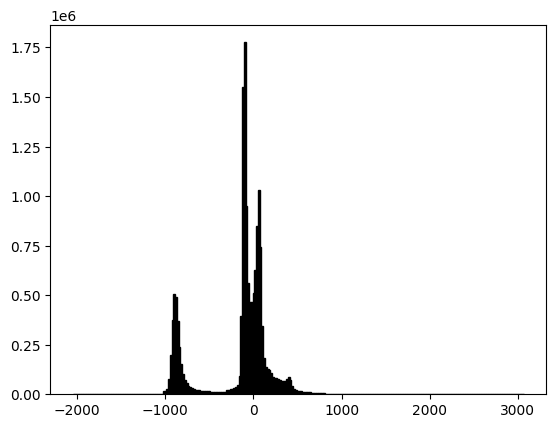

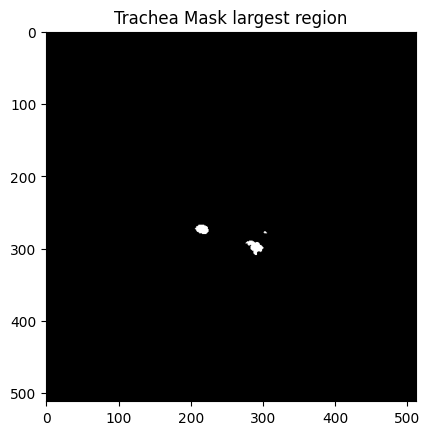

TypeError: local_maxima() got an unexpected keyword argument 'labels'

In [161]:
main('Images/IMG_0001.nii.gz','ReferenceSegmentations/LUNGS_IMG_0001.nii.gz', 'BodyMasks/BODYMASK_IMG_0001.nii.gz', 'output.nii.gz')
